In [1]:
import sys
sys.path.insert(0,r"E:\Github\scqubits")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import scqubits as qubit
import importlib as imp
imp.reload(qubit)
import numpy as np
# import networkx as nx
import tqdm

The Hamiltonian parameters are

* $E_{J}=\frac{\hbar I_C}{2e}$ Josephson junction critical current,
* $E_{C}=\frac{e^2}{2C}$ Charge energy, 
* $E_{L}=(\frac{\hbar}{2e})^2\frac{1}{2L}$ Inductor energy.
* $\Phi_x = \frac{2e \Phi}{\hbar}$ External applied flux, in units of radians

where 2e=1 and $\hbar$=1
* $I_C=E_{J}$ ,
* $C=\frac{1}{8E_c} $
* $L=\frac{1}{2E_{L}}$ Inverse superinductor inductance.


# Defining circuit topology

In [8]:
flux_qubit = qubit.Circuit()
flux_qubit.add_element(qubit.Capacitance('Cg1'), ['g1', '1'])
flux_qubit.add_element(qubit.Capacitance('Cg2'), ['g2', '2'])
flux_qubit.add_element(qubit.Capacitance('CJ1'), ['GND', '1'])
flux_qubit.add_element(qubit.Capacitance('CJ2'), ['GND', '2'])
flux_qubit.add_element(qubit.Capacitance('CJ3'), ['1', '3'])
flux_qubit.add_element(qubit.JosephsonJunction('J1'), ['GND', '1'])
flux_qubit.add_element(qubit.JosephsonJunction('J2'), ['GND', '2'])
flux_qubit.add_element(qubit.JosephsonJunction('J3'), ['1', '3'])

# Parametrizing Hamiltonian

In [9]:
ϕ1 = qubit.Variable('ϕ_1')
ϕ2 = qubit.Variable('ϕ_2')
f = qubit.Variable('f')
g1 = qubit.Variable('g_1')
g2 = qubit.Variable('g_2')

flux_qubit.add_variable(ϕ1)
flux_qubit.add_variable(ϕ2)
flux_qubit.add_variable(f)
flux_qubit.add_variable(g1)
flux_qubit.add_variable(g2)

# Mapping nodal phases to variables

In [44]:
"""
A*x=b, b is a node vector=['GND', '1', '2', '3', 'g1', 'g2']
x is a variable vector= ['ϕ_1', 'ϕ_2', 'f', 'g_1', 'g_2']
f - external flux, and should be specified as an additional node and a variable 

"""
flux_qubit.map_nodes_linear(['GND', '1', '2', '3', 'g1', 'g2'],
                            ['ϕ_1', 'ϕ_2', 'f', 'g_1', 'g_2'],
                            np.asarray([[0,   0,   0,   0,   0],
                                        [1,   0,   0,   0,   0],
                                        [0,   1,   0,   0,   0],
                                        [0,   1,  -1,   0,   0],
                                        [0,   0,   0,   1,   0],
                                        [0,   0,   0,   0,   1]]))

In [45]:
sympy.nsimplify(flux_qubit.symbolic_lagrangian())

-E_J1*(1 - cos(ϕ_1)) - E_J2*(1 - cos(ϕ_2)) - E_J3*(1 - cos(f + ϕ_1 - ϕ_2)) + \partial_tg_1*(C_g1*\partial_tg_1/2 - C_g1*\partial_tϕ_1/2) + \partial_tg_2*(C_g2*\partial_tg_2/2 - C_g2*\partial_tϕ_2/2) + \partial_tϕ_1*(-C_J3*(-\partial_tf/2 + \partial_tϕ_2/2) - C_g1*\partial_tg_1/2 + \partial_tϕ_1*(C_J1 + C_J3 + C_g1)/2) + \partial_tϕ_2*(-C_g2*\partial_tg_2/2 + \partial_tϕ_2*(C_J2 + C_g2)/2) + (-\partial_tf + \partial_tϕ_2)*(-C_J3*\partial_tϕ_1/2 + C_J3*(-\partial_tf/2 + \partial_tϕ_2/2))

# Separating variables into external controls and degrees of freedom

In [30]:
ϕ1.create_grid(21, 1) # 21 charge states, 2pi wavefunction periodicity
ϕ2.create_grid(21, 1) # 21 charge states, 2pi wavefunction periodicity
f.set_parameter(0.4*2*np.pi, 0) # external flux: 0.4 quantum, external voltage: 0
g1.set_parameter(0, 0) # external flux: 0 quanta, external voltage: 0
g2.set_parameter(0, 0) # external flux: 0 quanta, external voltage: 0

# Printing symbolic Hamiltonian (using sympy)
This part is a bit ugly, but in principle we could improve it so it uses better notation

In [31]:
import sympy
C_g1, C_g2, C_J1, C_J2, C_J3, E_J1, E_J2, E_J3 = \
    sympy.symbols('C_g1, C_g2, C_J1, C_J2, C_J3, E_J1, E_J2, E_J3')
flux_qubit.find_element('Cg1').set_capacitance(C_g1)
flux_qubit.find_element('Cg2').set_capacitance(C_g2)
flux_qubit.find_element('CJ1').set_capacitance(C_J1)
flux_qubit.find_element('CJ2').set_capacitance(C_J2)
flux_qubit.find_element('CJ3').set_capacitance(C_J3)
flux_qubit.find_element('J1').set_critical_current(E_J1)
flux_qubit.find_element('J2').set_critical_current(E_J2)
flux_qubit.find_element('J3').set_critical_current(E_J3)

## capacitance matrix in terms of the nodal parameterization

In [22]:
flux_qubit.capacitance_matrix(symbolic=True)

Matrix([
[C_J1 + C_J2,   0.0,              -C_J1,   0.0,       -C_J2,   0.0],
[        0.0,  C_g1,              -C_g1,   0.0,         0.0,   0.0],
[      -C_J1, -C_g1, C_J1 + C_J3 + C_g1,   0.0,         0.0, -C_J3],
[        0.0,   0.0,                0.0,  C_g2,       -C_g2,   0.0],
[      -C_J2,   0.0,                0.0, -C_g2, C_J2 + C_g2,   0.0],
[        0.0,   0.0,              -C_J3,   0.0,         0.0,  C_J3]])

## Legendre transform of the capacitance matrix (inverse wrt to degrees of freedom)

In [36]:
flux_qubit.capacitance_matrix_legendre_transform(symbolic=True)

Matrix([
[             1/(C_J2 + C_J3 + C_g1),                            0,                                        -(C_J2 - C_J3)/(C_J2 + C_J3 + C_g1),                                        -(C_J2 - C_g1)/(C_J2 + C_J3 + C_g1),                                                 -C_J2/(C_J2 + C_J3 + C_g1)],
[                                  0,              1/(C_J1 + C_g2),                                                        -C_J1/(C_J1 + C_g2),                                                        -C_J1/(C_J1 + C_g2),                                               -(C_J1 - C_g2)/(C_J1 + C_g2)],
[(-C_J2 + C_J3)/(C_J2 + C_J3 + C_g1),          -C_J1/(C_J1 + C_g2),              C_J1**2/(C_J1 + C_g2) + (C_J2 - C_J3)**2/(C_J2 + C_J3 + C_g1),   C_J1**2/(C_J1 + C_g2) + (C_J2 - C_J3)*(C_J2 - C_g1)/(C_J2 + C_J3 + C_g1), C_J1*(C_J1 - C_g2)/(C_J1 + C_g2) + C_J2*(C_J2 - C_J3)/(C_J2 + C_J3 + C_g1)],
[(-C_J2 + C_g1)/(C_J2 + C_J3 + C_g1),          -C_J1/(C_J1 + C_g2),   C_J1**2/(C_J1 + C_g2) + (C_J2 

## Symbolic lagrangian

In [37]:
sympy.nsimplify(flux_qubit.symbolic_lagrangian())

-E_J1*(1 - cos(f + g_1 + g_2 + ϕ_2)) - E_J2*(1 - cos(f + g_1 + g_2 + ϕ_1)) - E_J3*(1 - cos(f - ϕ_1)) + \partial_tf*(C_J3*\partial_tf/2 - C_J3*\partial_tϕ_1/2) + \partial_tg_1*(C_g1*\partial_tg_1/2 - C_g1*\partial_tϕ_1/2) + \partial_tg_2*(C_g2*\partial_tg_2/2 - C_g2*\partial_tϕ_2/2) + \partial_tϕ_1*(-C_J1*(\partial_tf/2 + \partial_tg_1/2 + \partial_tg_2/2 + \partial_tϕ_1/2 + \partial_tϕ_2/2) - C_J3*\partial_tf/2 - C_g1*\partial_tg_1/2 + \partial_tϕ_1*(C_J1 + C_J3 + C_g1)/2) + \partial_tϕ_2*(-C_J2*(\partial_tf/2 + \partial_tg_1/2 + \partial_tg_2/2 + \partial_tϕ_1/2 + \partial_tϕ_2/2) - C_g2*\partial_tg_2/2 + \partial_tϕ_2*(C_J2 + C_g2)/2) + (-C_J1*\partial_tϕ_1/2 - C_J2*\partial_tϕ_2/2 + (C_J1 + C_J2)*(\partial_tf/2 + \partial_tg_1/2 + \partial_tg_2/2 + \partial_tϕ_1/2 + \partial_tϕ_2/2))*(\partial_tf + \partial_tg_1 + \partial_tg_2 + \partial_tϕ_1 + \partial_tϕ_2)

## Symbolic hamiltonian

In [10]:
sympy.nsimplify(flux_qubit.symbolic_hamiltonian())

E_J1*(1 - cos(ϕ_1)) + E_J2*(1 - cos(ϕ_2)) + E_J3*(1 - cos(f + ϕ_1 - ϕ_2)) + \partial_tf*(\partial_tf*(C_J3*(-C_J3**2/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)) + C_J3*(C_J2 + C_J3 + C_g2)/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2))) - C_J3*(C_J3**2/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)) - C_J3*(C_J1 + C_J3 + C_g1)/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)))) + \partial_tg_1*(C_J3**2*C_g1/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)) - C_J3*C_g1*(C_J2 + C_J3 + C_g2)/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2))) + \partial_tg_2*(-C_J3**2*C_g2/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)) + C_J3*C_g2*(C_J1 + C_J3 + C_g1)/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2))) - I*\partial_{ϕ_1}*(C_J3**2/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2)) - C_J3*(C_J2 + C_J3 + C_g2)/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_J3 + C_g2))) - I*\partial_{ϕ_2}*(-C_J3**2/(-C_J3**2 + (C_J1 + C_J3 + C_g1)*(C_J2 + C_

# Replacing symbolic circuit parameters with some numbers

In [6]:
RATIO = 60.0
ALPHA = 0.8

flux_qubit.find_element('J1').set_critical_current(1.0)
flux_qubit.find_element('J2').set_critical_current(1.0)
flux_qubit.find_element('J3').set_critical_current(1.0*ALPHA)
flux_qubit.find_element('CJ1').set_capacitance(1/(8*1.0/RATIO))
flux_qubit.find_element('CJ2').set_capacitance(1/(8*1.0/RATIO))
flux_qubit.find_element('CJ3').set_capacitance(1/(8*1.0/RATIO/ALPHA))
flux_qubit.find_element('Cg1').set_capacitance(1/(8*50.0/RATIO))
flux_qubit.find_element('Cg2').set_capacitance(1/(8*50.0/RATIO))

# Eigenvalues and eigensystem using scqubit tools

In [7]:
flux_qubit.plot_potential()

AttributeError: 'Circuit' object has no attribute 'plot_potential'

In [8]:
vals, vecs= flux_qubit.eigensys()

In [9]:
vals
#vecs_phase = np.conj(unitary).T@vecs
vals - vals[0]

array([0.        , 0.26299666, 0.29339598, 0.50146767, 0.55310417,
       0.57154646])

# Eigenvalues using circuit tools

In [10]:
flux_qubit.calculate_potentials()
vals, vecs = flux_qubit.diagonalize_phase(num_states=6)

In [11]:
np.real(vals-vals[0])

array([0.        , 0.26299666, 0.29339598, 0.50146767, 0.55310417,
       0.57154646])

1.0000000000000142

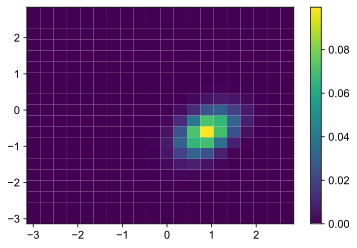

In [18]:
import matplotlib.pyplot as plt
vecs = np.reshape(vecs, (21,21,6))
plt.pcolormesh(ϕ1.get_phase_grid(), ϕ2.get_phase_grid(), np.abs(vecs[:,:,0])**2)
plt.colorbar()
np.sum(np.abs(vecs[:,:,0])**2)

### Playground

In [4]:
flux_qubit.nodes_grap

[('g1', '1'),
 ('g2', '2'),
 ('GND', '1'),
 ('GND', '2'),
 ('1', '3'),
 ('GND', '1'),
 ('GND', '2'),
 ('1', '3')]

In [7]:
G=nx.Graph(flux_qubit.nodes_graph)

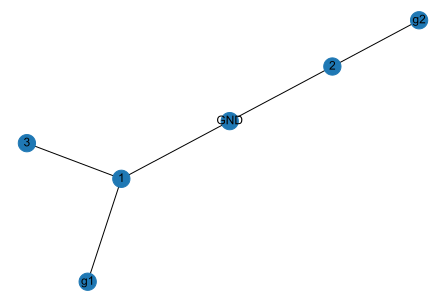

In [8]:
nx.draw(G,with_labels=True)

In [28]:
flux_qubit.wires

[('Cg1', 'g1'),
 ('Cg1', '1'),
 ('Cg2', 'g2'),
 ('Cg2', '2'),
 ('CJ1', 'GND'),
 ('CJ1', '1'),
 ('CJ2', 'GND'),
 ('CJ2', '2'),
 ('CJ3', '1'),
 ('CJ3', '3'),
 ('J1', 'GND'),
 ('J1', '1'),
 ('J2', 'GND'),
 ('J2', '2'),
 ('J3', '1'),
 ('J3', '3')]

# Transmon qubit

In [33]:
Transmon = qubit.Circuit()
Transmon.add_element(qubit.JosephsonJunction('JJ1'), ['GND', '1'])
Transmon.add_element(qubit.JosephsonJunction('JJ2'), ['1', '2'])
Transmon.add_element(qubit.Capacitance('Cq'), ['GND', '1'])

In [34]:
phi1 = qubit.Variable('φ1')
f = qubit.Variable('f')
ng = qubit.Variable('ng')

In [35]:
phi1.create_grid(32,1)
Transmon.add_variable(phi1)
Transmon.add_variable(f)
Transmon.add_variable(ng)

In [36]:
Transmon.map_nodes_linear(['GND', '1' , '2'], 
                       ['φ1', 'f','ng' ], 
                       np.asarray([[0,0,1],[1,0,0],[0,1,1]]))

In [28]:
import sympy
C, C_J1, C_J2, E_J1, E_J2 = \
    sympy.symbols('C, C_J1, C_J2, E_J1, E_J2')
Transmon.find_element('C').set_capacitance(C)
# Transmon.find_element('CJ1').set_capacitance(C_J1)
# Transmon.find_element('CJ2').set_capacitance(C_J2)/
Transmon.find_element('J1').set_critical_current(E_J1)
Transmon.find_element('J2').set_critical_current(E_J2)

In [13]:
sympy.nsimplify(Transmon.symbolic_lagrangian())

-E_J1*(1 - cos(ng - φ1)) - E_J2*(1 - cos(f + ng - φ1)) + \partial_tng*(C*\partial_tng/2 - C*\partial_tφ1/2) + \partial_tφ1*(-C*\partial_tng/2 + C*\partial_tφ1/2)

In [14]:
mat=Transmon.capacitance_matrix(symbolic=True)
mat

Matrix([
[  C,  -C, 0.0],
[ -C,   C, 0.0],
[0.0, 0.0, 0.0]])

In [15]:
Transmon.capacitance_matrix_legendre_transform(symbolic=True)

Matrix([
[1/C, 0, 1],
[  0, 0, 0],
[  1, 0, C]])

In [16]:
sympy.nsimplify(Transmon.symbolic_lagrangian())

-E_J1*(1 - cos(ng - φ1)) - E_J2*(1 - cos(f + ng - φ1)) + \partial_tng*(C*\partial_tng/2 - C*\partial_tφ1/2) + \partial_tφ1*(-C*\partial_tng/2 + C*\partial_tφ1/2)

In [17]:
sympy.nsimplify(Transmon.symbolic_hamiltonian())

E_J1*(1 - cos(ng - φ1)) + E_J2*(1 - cos(f + ng - φ1)) + \partial_tng*(C*\partial_tng - I*\partial_{φ1})/2 - I*\partial_{φ1}*(\partial_tng - I*\partial_{φ1}/C)/2

In [7]:
import tqdm as tqdm

In [38]:
"""
number of states should be less than grid discretiation 
create_grid(num,period)
num-1>num_states
"""
voltage_steps = 16
flux_steps=100
num_states=30
# energies = np.zeros((voltage_steps,num_states), dtype=np.float)
energies = np.zeros((flux_steps,num_states), dtype=np.float)
Ej1 = 15
Ej2 = 5
Ec = 0.200
Transmon.find_element('J1').set_critical_current(Ej1)
Transmon.find_element('J2').set_critical_current(Ej2)
Transmon.find_element('C').set_capacitance(1/(8*Ec))
f_value = 0
ng_value = 0

# for ng_id, ng_value in tqdm.tqdm(enumerate(np.linspace(-2, 2, voltage_steps)/8*Ec)):
for f_id, f_value in tqdm.tqdm(enumerate(np.linspace(-np.pi, np.pi, flux_steps))):
    f.set_parameter(f_value, 0)
    ng.set_parameter(0, ng_value)
    Transmon.calculate_potentials()
    [eigenenergies, eigenfunctions] = Transmon.diagonalize_phase(num_states=num_states)
#     energies[ng_id, :] = eigenenergies
    energies[f_id, :] = eigenenergies

0it [00:00, ?it/s]C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
100it [00:02, 47.57it/s]


In [16]:
(np.sqrt(8*(Ej1+Ej2)*Ec)-Ec),(np.sqrt(8*(Ej1-Ej2)*Ec)-Ec)

(5.45685424949238, 3.8)

In [30]:
np.mean((energies[:,1]-energies[:,0])-(energies[:,2]-energies[:,1]))

0.22323617731972875

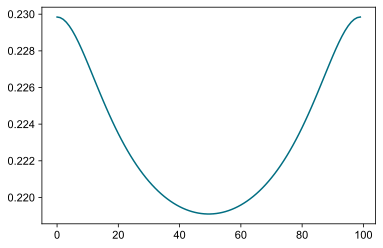

In [31]:
plt.plot((energies[:,1]-energies[:,0])-(energies[:,2]-energies[:,1]))

In [18]:
# np.mean((energies[:,1]-energies[:,0]))

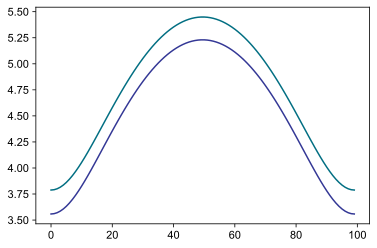

In [40]:
plt.plot((energies[:,1]-energies[:,0]))
plt.plot((energies[:,2]-energies[:,1]))

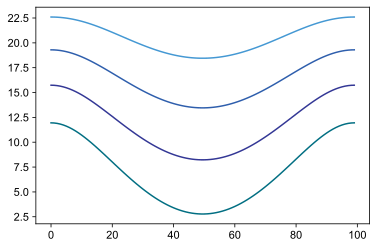

In [39]:
plt.plot(energies[:,:4])

In [184]:
Transmon.variables[2].variable_type

'parameter'

In [3]:
Tr

NameError: name 'Tr' is not defined

In [18]:
Transmon.capacitance_matrix_variables(False)

TypeError: can't convert expression to float

In [19]:
inverted_indices = [variable_id for variable_id, variable in enumerate(Transmon.variables) if variable.variable_type=='variable' ]
noninverted_indices = [variable_id for variable_id, variable in enumerate(Transmon.variables) if variable.variable_type=='parameter' ]

In [20]:
inverted_indices,noninverted_indices

([0], [1, 2])

In [21]:
Transmon.capacitance_matrix_variables(False)[tuple(np.meshgrid(inverted_indices, inverted_indices))].T

TypeError: can't convert expression to float

In [26]:
C = np.einsum('ji,jk,kl->il', Transmon.linear_coordinate_transform,Transmon.capacitance_matrix(True),Transmon.linear_coordinate_transform)

TypeError: invalid data type for einsum

In [23]:
Transmon.linear_coordinate_transform

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 1]])

In [25]:
Transmon.capacitance_matrix(True)

Matrix([
[  C,  -C, 0.0],
[ -C,   C, 0.0],
[0.0, 0.0, 0.0]])

In [30]:
import sympy
C = Transmon.linear_coordinate_transform.T*Transmon.capacitance_matrix(True)*Transmon.linear_coordinate_transform
print(C)
C = sympy.Matrix([sympy.nsimplify(sympy.ratsimp(x)) for x in C]).reshape(*(C.shape))

Matrix([[C, 0, -C], [0, 0, 0], [-C, 0, C]])


In [29]:
C

Matrix([
[ C, 0, -C],
[ 0, 0,  0],
[-C, 0,  C]])

# Two coupled transmon qubits

In [3]:
Transmons = qubit.Circuit()
Transmons.add_element(qubit.Capacitance('Cq1'), ['GND', '1'])
Transmons.add_element(qubit.JosephsonJunction('J1q1'), ['GND', '1'])
Transmons.add_element(qubit.JosephsonJunction('J2q1'), ['1', '2'])

Transmons.add_element(qubit.Capacitance('Cq2'), ['GND', '3'])
Transmons.add_element(qubit.JosephsonJunction('J1q2'), ['GND', '3'])
Transmons.add_element(qubit.JosephsonJunction('J2q2'), ['3', '4'])

Transmons.add_element(qubit.Capacitance('Cc'), ['1', '3'])


In [4]:
phi1 = qubit.Variable('φ1')
f1 = qubit.Variable('f1')
phi2 = qubit.Variable('φ2')
f2 = qubit.Variable('f2')
phi1.create_grid(32,1)
phi2.create_grid(32,1)

In [5]:
Transmons.add_variable(phi1)
Transmons.add_variable(phi2)
Transmons.add_variable(f1)
Transmons.add_variable(f2)

In [6]:
Transmons.map_nodes_linear(node_names=['GND', '1' , '2','3','4'], 
                           variable_names=['φ1','φ2', 'f1','f2' ], 
                           coefficients = 
                           np.asarray([[0,0,0,0],
                                       [1,0,0,0],
                                       [0,0,-1,0],
                                       [0,1,0,0],
                                       [0,0,0,-1]]))

In [93]:
import sympy
Cq1, E_J1q1, E_J2q1, Cq2, E_J1q2, E_J2q2,Cc,L = \
    sympy.symbols('Cq1,E_J1q1, E_J2q1,Cq2,E_J1q2, E_J2q2,Cc,L')
Transmons.find_element('Cq1').set_capacitance(Cq1)
Transmons.find_element('J1q1').set_critical_current(E_J1q1)
Transmons.find_element('J2q1').set_critical_current(E_J2q1)
Transmons.find_element('Cq2').set_capacitance(Cq2)
# Transmons.find_element('L').set_critical_current(L)
Transmons.find_element('Cc').set_capacitance(Cc)
Transmons.find_element('J1q2').set_critical_current(E_J1q2)
Transmons.find_element('J2q2').set_critical_current(E_J2q2)

In [95]:
sympy.nsimplify(Transmons.capacitance_matrix(symbolic=True))

Matrix([
[Cq1 + Cq2,     -Cq1, 0,     -Cq2, 0],
[     -Cq1, Cc + Cq1, 0,      -Cc, 0],
[        0,        0, 0,        0, 0],
[     -Cq2,      -Cc, 0, Cc + Cq2, 0],
[        0,        0, 0,        0, 0]])

In [96]:
sympy.nsimplify(Transmons.capacitance_matrix_legendre_transform(symbolic=True))

Matrix([
[(Cc + Cq2)/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2), 0,         Cc/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2), 0],
[                                     0, 0,                                      0, 0],
[        Cc/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2), 0, (Cc + Cq1)/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2), 0],
[                                     0, 0,                                      0, 0]])

In [66]:
sympy.nsimplify(Transmons.symbolic_lagrangian())

-E_J1q1*(1 - cos(φ1)) - E_J1q2*(1 - cos(φ2)) - E_J2q1*(1 - cos(f1 + φ1)) - E_J2q2*(1 - cos(f2 + φ2)) + \partial_tφ1*(-Cc*\partial_tφ2/2 + \partial_tφ1*(Cc + Cq1)/2) + \partial_tφ2*(-Cc*\partial_tφ1/2 + \partial_tφ2*(Cc + Cq2)/2)

In [70]:
sympy.nsimplify(Transmons.symbolic_hamiltonian().xreplace({sympy.Symbol('φ1'):0}))

E_J1q2*(1 - cos(φ2)) + E_J2q1*(1 - cos(f1)) + E_J2q2*(1 - cos(f2 + φ2)) - I*\partial_{φ1}*(-I*Cc*\partial_{φ2}/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2) - I*\partial_{φ1}*(Cc + Cq2)/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2))/2 - I*\partial_{φ2}*(-I*Cc*\partial_{φ1}/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2) - I*\partial_{φ2}*(Cc + Cq1)/(Cc*Cq1 + Cc*Cq2 + Cq1*Cq2))/2

In [8]:
imp.reload(qubit)

<module 'scqubits' from 'E:\\Github\\scqubits\\scqubits\\__init__.py'>

In [36]:
flux_steps1=10
flux_steps2=10
num_states=6

energies = np.zeros((flux_steps1,flux_steps2,num_states), dtype=np.float)
Ej1q1 = 40e9
Ej2q1 = 5e9
Ej1q2 = 12e9
Ej2q2 = 4e9
Ecq1 = 0.2e9
Ecq2 = 0.2e9
Ec=10e6
Transmons.find_element('Cq1').set_capacitance(1/(8*Ecq1))
Transmons.find_element('J1q1').set_critical_current(Ej1q1)
Transmons.find_element('J2q1').set_critical_current(Ej2q1)
Transmons.find_element('Cq2').set_capacitance(1/(8*Ecq2))
Transmons.find_element('Cc').set_capacitance(1/(8*Ec))
Transmons.find_element('J1q2').set_critical_current(Ej1q2)
Transmons.find_element('J2q2').set_critical_current(Ej2q2)


for f_id1, f1_value in enumerate(np.linspace( np.pi,-np.pi, flux_steps1)):
    for f_id2, f2_value in enumerate(np.linspace(-np.pi, np.pi, flux_steps2)):
        f1.set_parameter(f1_value, 0)
        f2.set_parameter(f2_value, 0)
        Transmons.calculate_potentials()
        [eigenenergies, eigenfunctions] = Transmons.diagonalize_phase(num_states=num_states,maxiter=2000)
        energies[f_id1,f_id2, :] = eigenenergies

C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


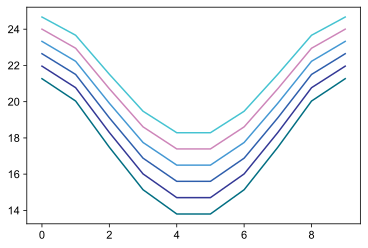

In [38]:
plt.figure()
# plt.plot(energies[:,0,:]/1e9)
plt.plot(energies[0,:,:]/1e9)

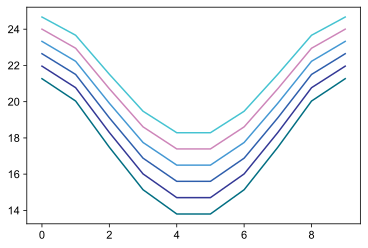

In [39]:
plt.plot(energies[0,:,:]/1e9)

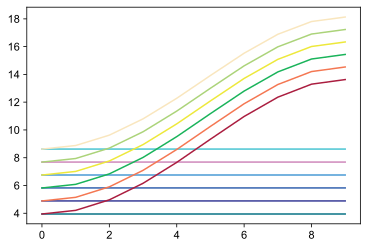

In [27]:
plt.figure()
plt.plot(energies[:,0,:]/1e9)
plt.plot(energies[0,:,:]/1e9)

In [100]:
(np.sqrt(8*(Ej1q1-Ej2q1)*Ecq1)-Ecq1),(np.sqrt(8*(Ej1q2-Ej2q2)*Ecq2)-Ecq2)

(2628427124.74619, 3975235392.6806064)

In [106]:
energies[0,:]

array([2.76219444e-06, 3.90697674e+07, 3.90697674e+07, 1.56279070e+08,
       1.56279070e+08, 3.51627907e+08, 3.51627907e+08, 4.27906977e+08,
       4.27906977e+08, 4.29767442e+08])

In [101]:
energies[:,1]-energies[:,0]

array([39069767.44185367, 39069767.4418956 , 39069767.44189874,
       39069767.44186108, 39069767.4418245 , 39069767.44188809,
       39069767.44189385, 39069767.44186915, 39069767.441887  ,
       39069767.4418683 ])

In [102]:
energies[:,2]-energies[:,1]

array([3.39373946e-05, 3.52561474e-05, 4.01884317e-05, 1.84923410e-05,
       5.73992729e-05, 2.04890966e-06, 7.54743814e-06, 2.74181366e-06,
       4.32133675e-06, 2.23219395e-05])

In [84]:
energies[1,:]

array([8.79816185e-06, 7.99840067e+08, 7.99840067e+08, 8.79806481e+08,
       8.79806481e+08, 1.67929470e+09, 1.67929470e+09, 1.67999840e+09,
       1.67999840e+09, 3.19936027e+09])

In [85]:
energies[0,:]

array([5.66575447e-06, 7.99840067e+08, 7.99840067e+08, 8.79806481e+08,
       8.79806481e+08, 1.67929470e+09, 1.67929470e+09, 1.67999840e+09,
       1.67999840e+09, 3.19936027e+09])

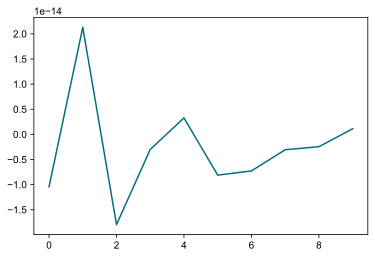

In [75]:
plt.plot(energies[:,0])

In [38]:
energies[1,:]-energies[0,:]

array([-1.96407225e-14, -3.39728246e-14, -3.14193116e-14, -7.03881398e-14,
       -3.15303339e-14, -6.90558721e-14, -4.21884749e-14, -5.06261699e-14,
       -5.66213743e-14, -4.17443857e-14])

In [37]:
energies[1,:]

array([2.56540418e-15, 8.00000000e-01, 8.00000000e-01, 8.80000000e-01,
       8.80000000e-01, 1.68000000e+00, 1.68000000e+00, 1.68000000e+00,
       1.68000000e+00, 3.20000000e+00])